## SVM Analysis
Author: Andy Malinsky

In [2]:
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

np.random.seed(24)

## Data Preparation

In [3]:
# Load Data info dataframe
datasets = ['harth/S006.csv', 
            'harth/S008.csv',
            'harth/S009.csv',
            'harth/S010.csv',
            'harth/S012.csv',
            'harth/S013.csv',
            'harth/S014.csv',
            'harth/S015.csv',
            'harth/S016.csv',
            'harth/S017.csv',
            'harth/S018.csv',
            'harth/S019.csv',
            'harth/S020.csv',
            'harth/S021.csv',
            'harth/S022.csv',
            'harth/S023.csv',
            'harth/S024.csv',
            'harth/S025.csv',
            'harth/S026.csv',
            'harth/S027.csv',
            'harth/S028.csv',
            'harth/S029.csv']
df = pd.concat(map(pd.read_csv, datasets), ignore_index=True) 
df = df[['timestamp','back_x','back_y','back_z','thigh_x','thigh_y','thigh_z','label']]
df.head()

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2019-01-12 00:00:00.000,-0.760242,0.299570,0.468570,-5.092732,-0.298644,0.709439,6
1,2019-01-12 00:00:00.010,-0.530138,0.281880,0.319987,0.900547,0.286944,0.340309,6
2,2019-01-12 00:00:00.020,-1.170922,0.186353,-0.167010,-0.035442,-0.078423,-0.515212,6
3,2019-01-12 00:00:00.030,-0.648772,0.016579,-0.054284,-1.554248,-0.950978,-0.221140,6
4,2019-01-12 00:00:00.040,-0.355071,-0.051831,-0.113419,-0.547471,0.140903,-0.653782,6


In [4]:
activity_label = {
    1: '1: Walking',
    2: '2: Running',
    3: '3: Shuffling',
    4: '4: Stairs (Ascending)',
    5: '5: Stairs (Descending)',
    6: '6: Standing',
    7: '7: Sitting',
    8: '8: Lying',
    13: '9: Cycling (Sit)',
    14: '10: Cycling (Stand)',
    130: '11: Cycling (Sit, Inactive)',
    140: '12: Cycling (Stand, Inactive)'
}
df_map = df.copy()
df_map['label'] = df['label'].replace(activity_label)
df_map

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2019-01-12 00:00:00.000,-0.760242,0.299570,0.468570,-5.092732,-0.298644,0.709439,6: Standing
1,2019-01-12 00:00:00.010,-0.530138,0.281880,0.319987,0.900547,0.286944,0.340309,6: Standing
2,2019-01-12 00:00:00.020,-1.170922,0.186353,-0.167010,-0.035442,-0.078423,-0.515212,6: Standing
3,2019-01-12 00:00:00.030,-0.648772,0.016579,-0.054284,-1.554248,-0.950978,-0.221140,6: Standing
4,2019-01-12 00:00:00.040,-0.355071,-0.051831,-0.113419,-0.547471,0.140903,-0.653782,6: Standing
...,...,...,...,...,...,...,...,...
6461323,2019-01-12 00:59:56.940,-1.012939,-0.110840,-0.218994,-0.970215,-0.313232,0.124268,3: Shuffling
6461324,2019-01-12 00:59:56.960,-0.979492,-0.089355,-0.216553,-0.966553,-0.234619,0.113770,3: Shuffling
6461325,2019-01-12 00:59:56.980,-0.969971,-0.057861,-0.204590,-0.997803,-0.097656,0.065186,3: Shuffling
6461326,2019-01-12 00:59:57.000,-1.001953,-0.029785,-0.234863,-1.000000,-0.145996,0.061523,3: Shuffling


In [5]:
# function to split into scaled independent and dependent
def split_and_scale_data(df, cal_test=False):
    # Split Features Into Independent and Dependent
    x = df[['back_x','back_y','back_z','thigh_x','thigh_y','thigh_z']]
    y = df[['label']].values.ravel()
    
    # Standardize and Normalize Data
    scaler = StandardScaler().fit(x)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = pd.DataFrame(min_max_scaler.fit_transform(scaler.transform(x)), columns=list(x.columns.tolist()), index=x.index)
    if not cal_test:
        print('Mean:\n', x_scaled.mean())
        print('\nStandard deviation:\n', x_scaled.std())
    x_scaled.head()
    
    return x_scaled, y

In [6]:
x_scaled, y = split_and_scale_data(df_map)

Mean:
 back_x     0.691337
back_y     0.397642
back_z     0.557743
thigh_x    0.462827
thigh_y    0.501229
thigh_z    0.510472
dtype: float64

Standard deviation:
 back_x     0.036689
back_y     0.021406
back_z     0.031761
thigh_x    0.039147
thigh_y    0.024283
thigh_z    0.044867
dtype: float64


## Exploratory Data Analysis

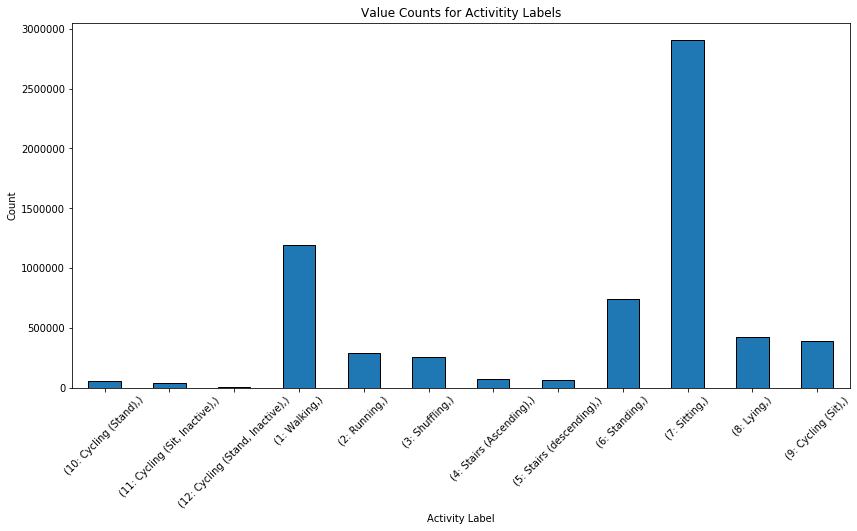

In [81]:
# Histogram of activity label value counts
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
df_map[['label']].value_counts().sort_index().plot(kind='bar', ax=ax, edgecolor='black')
ax.set_xlabel('Activity Label')
ax.set_ylabel('Count')
ax.set_title('Value Counts for Activitity Labels')
fig.tight_layout()
plt.xticks(rotation=45)
plt.show()

## SVM Model Training and Analysis

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=24)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (5169062, 6)
x_test shape: (1292266, 6)
y_train shape: (5169062,)
y_test shape: (1292266,)


In [6]:
clf = SGDClassifier(random_state=24)
clf.fit(x_train, y_train) 
y_pred = clf.predict(x_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred)) # Evaluate model performance
print(classification_report(y_test, y_pred))

Accuracy: 0.6210710488397899
              precision    recall  f1-score   support

           1       0.51      0.13      0.21    239884
           2       0.20      0.00      0.00     57811
           3       0.00      0.00      0.00     50976
           4       0.00      0.00      0.00     15231
           5       0.00      0.00      0.00     13446
           6       0.35      0.88      0.51    148400
           7       0.76      0.98      0.86    580847
           8       0.61      0.83      0.70     85958
          13       0.00      0.00      0.00     78645
          14       0.02      0.00      0.00     11171
         130       0.00      0.00      0.00      8314
         140       0.00      0.00      0.00      1583

    accuracy                           0.62   1292266
   macro avg       0.21      0.24      0.19   1292266
weighted avg       0.53      0.62      0.53   1292266



## Hyperparameter Tuning

In [11]:
param_grid = {
    'alpha': [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7], # learning rate
    'loss': ['log', 'hinge', 'modified_huber'], # loss function
    'n_jobs': [-1],
    'random_state': [24]
}
grid = GridSearchCV(SGDClassifier(), param_grid, refit = True, verbose = 3, cv=5, n_jobs=-1) # 5 fold cross validation
grid.fit(x_train, y_train) # fitting the model for grid search 
print(grid.best_params_) # print best parameter after tuning 
print(grid.best_estimator_) # print how our model looks after hyper-parameter tuning 

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 28.2min finished


{'alpha': 1e-07, 'loss': 'hinge', 'n_jobs': -1, 'random_state': 24}
SGDClassifier(alpha=1e-07, n_jobs=-1, random_state=24)


In [8]:
clf = SGDClassifier(alpha=1e-7, loss='hinge', random_state=24, n_jobs=-1)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred), 2)) # Evaluate model performance
print(classification_report(y_test, y_pred))

Accuracy: 0.63
                               precision    recall  f1-score   support

          10: Cycling (Stand)       0.00      0.00      0.00     11171
  11: Cycling (Sit, Inactive)       0.00      0.00      0.00      8314
12: Cycling (Stand, Inactive)       0.00      0.00      0.00      1583
                   1: Walking       0.46      0.10      0.16    239884
                   2: Running       0.41      0.02      0.04     57811
                 3: Shuffling       0.00      0.00      0.00     50976
        4: Stairs (Ascending)       0.00      0.00      0.00     15231
       5: Stairs (Descending)       0.00      0.00      0.00     13446
                  6: Standing       0.31      0.97      0.46    148400
                   7: Sitting       0.85      0.98      0.91    580847
                     8: Lying       0.82      0.90      0.85     85958
             9: Cycling (Sit)       0.00      0.00      0.00     78645

                     accuracy                           0.63

In [14]:
# K-Fold Cross Validation
scores = cross_val_score(clf, x_scaled, y, cv=5, n_jobs=-1)
print('5 K-Fold Validation Average Score:', round(np.mean(scores), 2))

5 K-Fold Validation Average Score: 0.61


## Metabolic Calorie Counter Experiment

In [52]:
# Hypothetical calorie burn values (calories per minute) based on activity intensity
calorie_burn_rates = {
    1: 4,       # 'Walking'
    2: 10,      # 'Running'
    3: 3,       # 'Shuffling'
    4: 8,       # 'Stairs (Ascending)'
    5: 7,       # 'Stairs (Descending)'
    6: 1.5,     # 'Standing'
    7: 1,       # 'Sitting'
    8: 0.8,     # 'Lying'
    13: 6,      # 'Cycling (Sit)'
    14: 9,      # 'Cycling (Stand)'
    130: 2,     # 'Cycling (Sit, Inactive)'
    140: 2.5    # 'Cycling (Stand, Inactive)'
}
activity_label_inv = {v: k for k, v in activity_label.items()} # inverse label map

# Function to test prediction per person
def predict_calories_burned(dataPath):
    print('\nRunning Test for:', dataPath)
    data = pd.read_csv(dataPath)
    d_x, d_y = split_and_scale_data(data, True)
    d_pred = list(map(activity_label_inv.get, clf.predict(d_x)))
    cosine_sim = round(cosine_similarity([d_pred], [d_y])[0][0], 2)
    label_variance = round(np.var(d_y), 2)
    print('Cosine similarity Predicted vs Actual:', cosine_sim) # cosine similarity of predicted vs actual labels
    
    # Calculate calories burned on actual vs predicted
    sum_act_cal = 0
    sum_pred_cal = 0
    for i in range(0, len(d_y)):
        sum_act_cal += calorie_burn_rates[d_y[i]]
        sum_pred_cal += calorie_burn_rates[d_pred[i]]
    print('Total Actual Calories Burned:', round(sum_act_cal, 2))
    print('Total Predicted Calories Burned:', round(sum_pred_cal, 2))
    total_error = abs(round(sum_pred_cal - sum_act_cal, 2))
    print('Total Error (Predicted - Actual):', total_error)
    print('Variance in labels:', label_variance)
    
    return cosine_sim, label_variance, total_error

In [53]:
# Run Calorie Test on All Data Samples
cosine_similarities = []
label_variances = []
total_errors = []

for dataset in datasets:
    cosine_sim, label_variance, total_error =  predict_calories_burned(dataset)
    cosine_similarities.append(cosine_sim)
    label_variances.append(label_variance)
    total_errors.append(total_error)


Running Test for: harth/S006.csv
Cosine similarity Predicted vs Actual: 0.45
Total Actual Calories Burned: 717915.8
Total Predicted Calories Burned: 408895.3
Total Error (Predicted - Actual): 309020.5
Variance in labels: 413.24

Running Test for: harth/S008.csv
Cosine similarity Predicted vs Actual: 0.72
Total Actual Calories Burned: 628091.0
Total Predicted Calories Burned: 419536.5
Total Error (Predicted - Actual): 208554.5
Variance in labels: 41.55

Running Test for: harth/S009.csv
Cosine similarity Predicted vs Actual: 0.56
Total Actual Calories Burned: 879852.0
Total Predicted Calories Burned: 159519.2
Total Error (Predicted - Actual): 720332.8
Variance in labels: 887.37

Running Test for: harth/S010.csv
Cosine similarity Predicted vs Actual: 0.79
Total Actual Calories Burned: 1046180.5
Total Predicted Calories Burned: 349134.1
Total Error (Predicted - Actual): 697046.4
Variance in labels: 6.37

Running Test for: harth/S012.csv
Cosine similarity Predicted vs Actual: 0.98
Total Ac

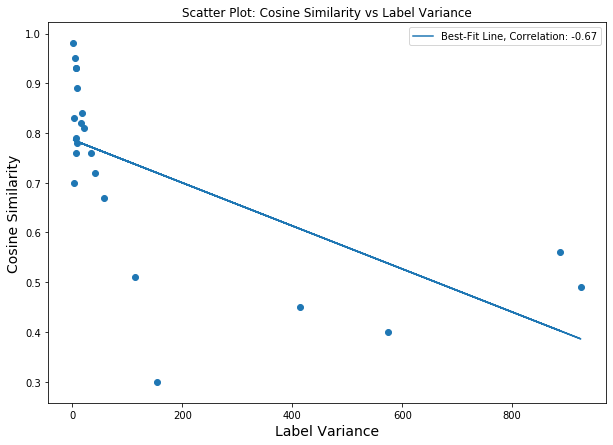

In [55]:
x = np.asarray(label_variances, dtype=np.float32)
y = np.asarray(cosine_similarities, dtype=np.float32)

fig = plt.figure(figsize=(10, 7))
plt.scatter(x, y)
plt.xlabel("Label Variance", size=14)
plt.ylabel("Cosine Similarity", size=14)
plt.title('Scatter Plot: Cosine Similarity vs Label Variance')
a, b = np.polyfit(x, y, 1) # find line of best fit
plt.plot(x, a*(x)+b) # add line of best fit to plot

# calculate correlation using the covariance and standard deviations
correlation = round((np.cov(x,y) / (x.std() * y.std()))[0,1], 2)
plt.legend(['Best-Fit Line, Correlation: '+str(correlation)], loc='upper right')
plt.show()

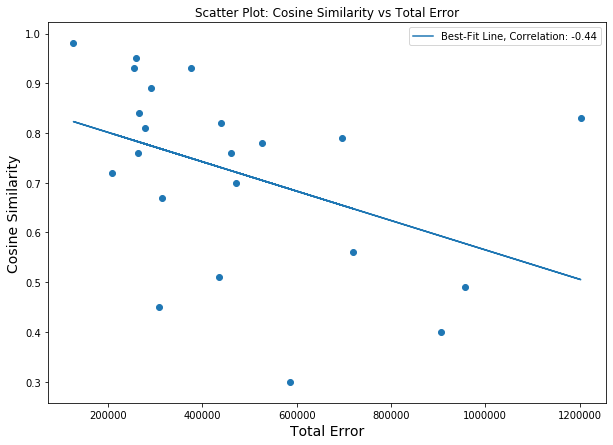

In [56]:
x = np.asarray(total_errors, dtype=np.float32)
y = np.asarray(cosine_similarities, dtype=np.float32)

fig = plt.figure(figsize=(10, 7))
plt.scatter(x, y)
plt.xlabel("Total Error", size=14)
plt.ylabel("Cosine Similarity", size=14)
plt.title('Scatter Plot: Cosine Similarity vs Total Error')
a, b = np.polyfit(x, y, 1) # find line of best fit
plt.plot(x, a*(x)+b) # add line of best fit to plot

# calculate correlation using the covariance and standard deviations
correlation = round((np.cov(x,y) / (x.std() * y.std()))[0,1], 2)
plt.legend(['Best-Fit Line, Correlation: '+str(correlation)], loc='upper right')
plt.show()

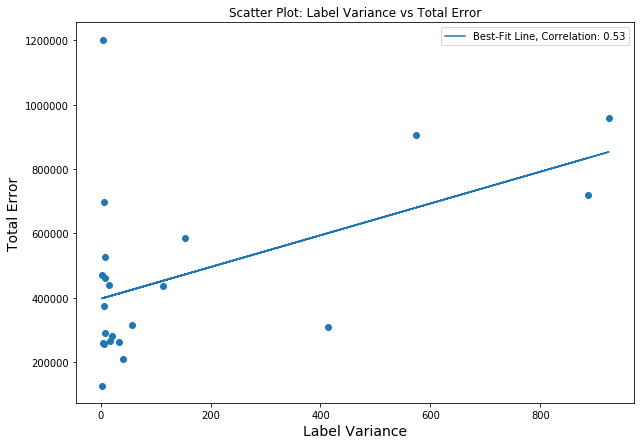

In [57]:
x = np.asarray(label_variances, dtype=np.float32)
y = np.asarray(total_errors, dtype=np.float32)

fig = plt.figure(figsize=(10, 7))
plt.scatter(x, y)
plt.xlabel("Label Variance", size=14)
plt.ylabel("Total Error", size=14)
plt.title('Scatter Plot: Label Variance vs Total Error')
a, b = np.polyfit(x, y, 1) # find line of best fit
plt.plot(x, a*(x)+b) # add line of best fit to plot

# calculate correlation using the covariance and standard deviations
correlation = round((np.cov(x,y) / (x.std() * y.std()))[0,1], 2)
plt.legend(['Best-Fit Line, Correlation: '+str(correlation)], loc='upper right')
plt.show()